In [1]:
# import packages

# basics
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import markers
from collections import OrderedDict
from itertools import cycle

# scikit-learn imports
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# torch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.utils import make_grid

In [70]:
# Check CPU / GPU environment
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Training on GPU
    print("GPU is available")
else:
    device = torch.device("cpu") # Training on CPU
    print("GPU not available, CPU used")

GPU is available


In [2]:
torch.manual_seed(20210412)
np.random.seed(20210412)

by following the [pytorch CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

# 1. Data Loading & Manipulation

***The CIFAR-10 dataset***
collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton from the University of Toronto. This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. Each image is a 3-channel colour images of 32x32 pixels in size. There are 50000 training images and 10000 test images.

In [57]:
# test mode 
debug_mode = False

### Download the dataset

In [58]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_batch_size = 1000 if debug_mode else len(trainset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=2)

# Load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

test_batch_size = 1000 if debug_mode else len(testset)

testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

Files already downloaded and verified
Files already downloaded and verified


### Preview data

In [4]:
img, label = trainset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 frog


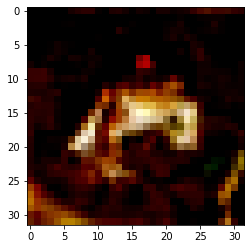

In [5]:
plt.imshow(img.permute((1, 2, 0)))
print(label, classes[label])

### Pre-processing for SVM

In [6]:
# trainset
# convert tensor data(image, label) into numpy array
train_dataset_array, train_dataset_targets =  next(iter(trainloader)) # get a single batch from a trainloader
train_dataset_array = train_dataset_array.numpy()
train_dataset_targets = train_dataset_targets.numpy()

# testset
# convert tensor data(label) into numpy array
test_dataset_array, test_dataset_targets =  next(iter(testloader))
test_dataset_array = test_dataset_array.numpy()
test_dataset_targets = test_dataset_targets.numpy()

In [7]:
# Preprocessing for SVM (flatten the images)
d_image, h_image, w_image = train_dataset_array.shape[1:] # (3, 32, 32)->depth(=color) 3*height 32*width 32=3072
X_Train = train_dataset_array.reshape((train_dataset_array.shape[0], d_image*h_image*w_image))

d_image, h_image, w_image = test_dataset_array.shape[1:] # (3, 32, 32)->3*32*32=3072
X_Test = test_dataset_array.reshape((test_dataset_array.shape[0], d_image*h_image*w_image))

# 2. Initial Data Analysis

### Extract a subset with only two classes: Cat(3), Dog(5) for quick overview

In [8]:
cat_dog_train = train_dataset_array[np.where((train_dataset_targets == 3) | (train_dataset_targets == 5))]
cat_dog_train_targets = train_dataset_targets[np.where((train_dataset_targets == 3) | (train_dataset_targets == 5))]

cat_dog_test = test_dataset_array[np.where((test_dataset_targets == 3) | (test_dataset_targets == 5))]
cat_dog_test_targets = test_dataset_targets[np.where((test_dataset_targets == 3) | (test_dataset_targets == 5))]

In [9]:
# Preprocessing for SVM (flatten the images)
d_catDog, h_catDog, w_catDog = cat_dog_train.shape[1:] # (3, 32, 32)->depth(=color) 3*height 32*width 32=3072
cat_dog_train_reshape = cat_dog_train.reshape((cat_dog_train.shape[0], d_catDog*h_catDog*w_catDog)) # (10000, 3072)

d_catDog, h_catDog, w_catDog = cat_dog_test.shape[1:] # (3, 32, 32)->3*32*32=3072
cat_dog_test_reshape = cat_dog_test.reshape((cat_dog_test.shape[0], d_catDog*h_catDog*w_catDog)) # (2000, 3072)

In [10]:
# Apply PCA on the training set to reduce the dimensionality.

pca_obs = [] # store 7 values(𝑘1,𝑘2,...,𝑘7) in a list

for i in range(7):
    no_components = 3 *(i+1)*(i+1) # squared values from 1 to 7
    pca_obs.append(PCA(n_components = no_components, svd_solver='randomized', whiten=True).fit(cat_dog_train_reshape))

Text(0.5, 0, 'Principle component number')

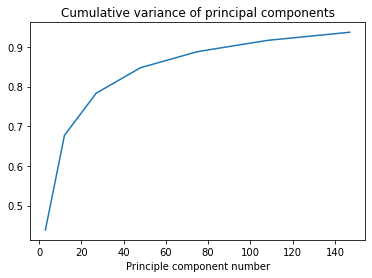

In [11]:
# Plot cumulative variance
y_vals = [x.explained_variance_ratio_.sum() for x in pca_obs]
x_vals = [x.n_components for x in pca_obs]
plt.plot(x_vals, y_vals)
plt.title('Cumulative variance of principal components')
plt.xlabel('Principle component number')  

In [12]:
SVM_training_time = []
SVM_test_time = []
SVM_train_acc = []
SVM_test_acc = []
SVM_fpr = []
SVM_tpr = []

classifier = SVC(random_state = 0, probability=True)

for i in range(7): # seven on PCA features with seven different dimension
    pca_obj = pca_obs[i]
    pca_train = pca_obj.transform(cat_dog_train_reshape)
    pca_test = pca_obj.transform(cat_dog_test_reshape)

    t0 = time.time()
    model = classifier.fit(pca_train, cat_dog_train_targets) # SVM
    t1 = time.time() - t0
    SVM_training_time.append(t1)

    # classification accuracy
    SVM_train_acc.append(model.score(pca_train, cat_dog_train_targets))
    SVM_test_acc.append(model.score(pca_test, cat_dog_test_targets))
    
    t0 = time.time()
    pred = model.predict(pca_test)
    t1 = time.time() - t0
    SVM_test_time.append(t1)
    
    # ROC curves
    pred_prob = model.predict_proba(pca_test)
    fpr, tpr, _ = roc_curve(cat_dog_test_targets, pred, pos_label=5)
    SVM_fpr.append(fpr)
    SVM_tpr.append(tpr)

    print('Finished one loop')

Finished one loop
Finished one loop
Finished one loop
Finished one loop
Finished one loop
Finished one loop
Finished one loop


In [13]:
SVM_training_time, SVM_test_time, SVM_train_acc, SVM_test_acc

([10.938764333724976,
  14.555953025817871,
  20.531683206558228,
  29.844221591949463,
  47.246708393096924,
  68.62365579605103,
  94.10020732879639],
 [0.19932103157043457,
  0.28559446334838867,
  0.4928462505340576,
  0.7516677379608154,
  1.2885925769805908,
  1.898094892501831,
  2.7258846759796143],
 [0.5805, 0.6942, 0.7865, 0.8341, 0.8677, 0.8879, 0.8983],
 [0.5815, 0.624, 0.6535, 0.668, 0.673, 0.6725, 0.6845])

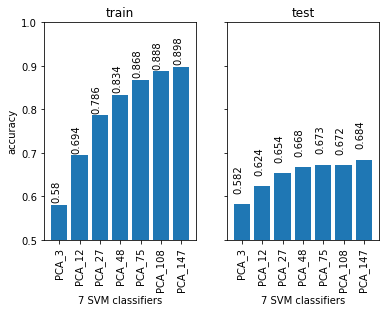

In [14]:
# Visualise their performance using a bar graph.
fig, axes = plt.subplots(nrows= 1, ncols=2, sharey=True)
x_axis = []
x_axis += ['PCA_'+str(x.n_components) for x in pca_obs] # x-axis label

plt.ylim(0.5, 1)
axes[0].set_ylabel("accuracy") # y-axis label

bar1 = axes[0].bar(x_axis, SVM_train_acc)
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(x_axis, rotation=90)
axes[0].set_title("train")
axes[0].set_xlabel("7 SVM classifiers")
for bar in bar1: # access the bar attributes to place the text in the appropriate location
    yval = bar.get_height()
    axes[0].text(bar.get_x(), yval + .01, round(yval, 3), rotation=90)
    
bar2 = axes[1].bar(x_axis, SVM_test_acc)
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(x_axis, rotation=90)
axes[1].set_title("test")
axes[1].set_xlabel("7 SVM classifiers")
for bar in bar2: # access the bar attributes to place the text in the appropriate location
    yval = bar.get_height()
    axes[1].text(bar.get_x(), yval + .03, round(yval, 3), rotation=90)

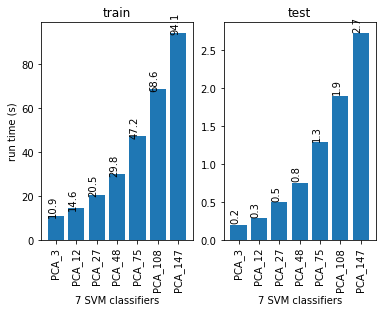

In [15]:
fig, axes = plt.subplots(nrows= 1, ncols=2)
x_axis = []
x_axis += ['PCA_'+str(x.n_components) for x in pca_obs] # x-axis label

axes[0].set_ylabel("run time (s)") # y-axis label

bar1 = axes[0].bar(x_axis, SVM_training_time)
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(x_axis, rotation=90)
axes[0].set_title("train")
axes[0].set_xlabel("7 SVM classifiers")
for bar in bar1: # access the bar attributes to place the text in the appropriate location
    yval = bar.get_height()
    axes[0].text(bar.get_x(), yval + .04, round(yval, 1), rotation=90)
    
bar2 = axes[1].bar(x_axis, SVM_test_time)
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(x_axis, rotation=90)
axes[1].set_title("test")
axes[1].set_xlabel("7 SVM classifiers")
for bar in bar2: # access the bar attributes to place the text in the appropriate location
    yval = bar.get_height()
    axes[1].text(bar.get_x(), yval + .04, round(yval, 1), rotation=90)

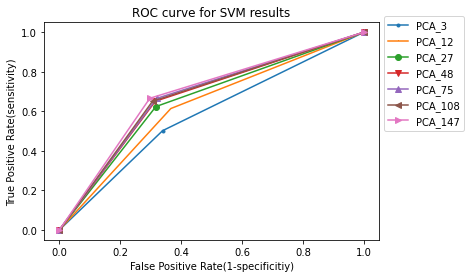

In [16]:
# Plot ROC curves for seven SVM classifiers in CatDog dataset

markers_array = markers.MarkerStyle.markers.keys()
marker = cycle(markers_array)
fig, axes = plt.subplots()
x_axis = []
x_axis += ['PCA_'+str(x.n_components) for x in pca_obs] #x-axis label

for i in range(7): #using 7 different line/marker styles clearly labelled.
    label = x_axis[i]
    axes.plot(SVM_fpr[i], SVM_tpr[i], marker=next(marker), label=label)
    
axes.set_title("ROC curve for SVM results")
axes.set_xlabel("False Positive Rate(1-specificitiy)")
axes.set_ylabel("True Positive Rate(sensitivity)")
plt.legend(bbox_to_anchor=(1.0, 1.05))

<AxesSubplot:>

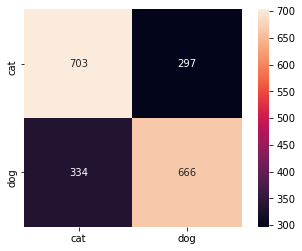

In [19]:
target_names = ['cat', 'dog']
sns.heatmap(confusion_matrix(cat_dog_test_targets, pred),
             square=True, annot=True, fmt='d',
             xticklabels = target_names, yticklabels = target_names)

# 3. Define two neural networks
## 3.1 SVM

In [21]:
# Train the network
total_training_time = []
train_accuracies = []

t0 = time.time()

classifier = SVC(random_state = 0, probability=True)
model = classifier.fit(X_Train, train_dataset_targets)

t1 = time.time() - t0
total_training_time.append(t1)
train_accuracies.append(model.score(X_Train, train_dataset_targets))

print('Finished Training')

Finished Training


In [22]:
total_test_time = []
test_accuracies = []

t0 = time.time()

svm_pred = classifier.predict(X_Test)

t1 = time.time() - t0
total_test_time.append(t1)
test_accuracies.append(model.score(X_Test, test_dataset_targets))

In [23]:
precision_recall_fscore_support(test_dataset_targets, svm_pred, average='macro')

(0.5424590496907443, 0.5436, 0.5420165358350894, None)

In [24]:
precision_recall_fscore_support(test_dataset_targets, svm_pred, average='micro')

(0.5436, 0.5436, 0.5436, None)

<AxesSubplot:>

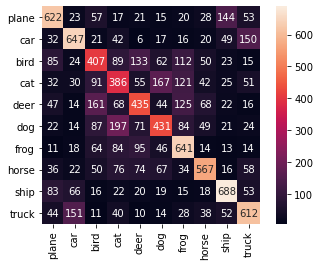

In [25]:
target_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(confusion_matrix(test_dataset_targets, svm_pred),
             square=True, annot=True, fmt='d',
             xticklabels = target_names, yticklabels = target_names)

## 3.2 MLP

In [117]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 64)
        self.linear4 = nn.Linear(64, 64)
        self.linear5 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Flatten images into vectors
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        x = F.relu(x)
        x = self.linear5(x)
        return x

mlp_net = MLPNet()
mlp_net = mlp_net.to(device)

In [118]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss() # Classification Cross-Entropy loss
optimizer = optim.SGD(mlp_net.parameters(), lr=0.001, momentum=0.9) # SGD with momentum

***switch the amount of train data size on demands***

In [119]:
train_batch_size = 1000 if debug_mode else 4
train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=2)

In [120]:
# Train the network
t0 = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers

        # forward + backward + optimize
        outputs = mlp_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # Does the update
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0        

        # test mode    
        if debug_mode:
            break 

t1 = time.time() - t0
total_training_time.append(t1)

print('Finished Training')

[1,  2000] loss: 2.148
[1,  4000] loss: 1.841
[1,  6000] loss: 1.730
[1,  8000] loss: 1.674
[1, 10000] loss: 1.638
[1, 12000] loss: 1.572
[2,  2000] loss: 1.494
[2,  4000] loss: 1.488
[2,  6000] loss: 1.474
[2,  8000] loss: 1.473
[2, 10000] loss: 1.417
[2, 12000] loss: 1.423
Finished Training


***switch the amount of train data size on demands***

In [121]:
test_batch_size = 1000 if debug_mode else 4
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [122]:
mlp_pred = []

correct = 0
total = 0
t0 = time.time()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = mlp_net(images)
        _, predicted = torch.max(outputs.data, 1)
        mlp_pred.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

t1 = time.time() - t0
total_test_time.append(t1)
test_accuracies.append(correct/total)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


<AxesSubplot:>

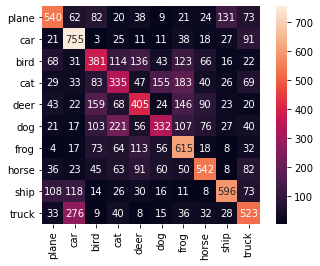

In [123]:
# Show the confusion matrix
mlp_pred = torch.squeeze(torch.cat(mlp_pred, 0))

target_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(confusion_matrix(test_dataset_targets, mlp_pred.cpu()),
             square=True, annot=True, fmt='d',
             xticklabels = target_names, yticklabels = target_names)

In [124]:
precision_recall_fscore_support(test_dataset_targets, mlp_pred.cpu(), average='macro')

(0.5027998821696029, 0.5024, 0.4984332052230019, None)

In [125]:
precision_recall_fscore_support(test_dataset_targets, mlp_pred.cpu(), average='micro')

(0.5024, 0.5024, 0.5024, None)

## Reference: CNN
***https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html***

In [140]:
# Train one Convoluational Neural Network
# as defined in the pytorch CIFAR10 tutorial.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 3-colors image channel, 6 output channels, 5x5 square kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # transform shape
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_net = Net()
cnn_net = cnn_net.to(device)

In [141]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss() # Classification Cross-Entropy loss
optimizer = optim.SGD(cnn_net.parameters(), lr=0.001, momentum=0.9) # SGD with momentum

In [142]:
# Train the network
t0 = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers

        # forward + backward + optimize
        outputs = cnn_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # Does the update

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

        # test mode    
        if debug_mode:
            break 

t1 = time.time() - t0
total_training_time.append(t1)

print('Finished Training')

[1,  2000] loss: 2.197
[1,  4000] loss: 1.904
[1,  6000] loss: 1.700
[1,  8000] loss: 1.593
[1, 10000] loss: 1.551
[1, 12000] loss: 1.451
[2,  2000] loss: 1.375
[2,  4000] loss: 1.357
[2,  6000] loss: 1.309
[2,  8000] loss: 1.304
[2, 10000] loss: 1.275
[2, 12000] loss: 1.248
Finished Training


In [143]:
test_batch_size = 1000 if debug_mode else 4
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [144]:
# Check accuracy after trainning one Convoluational Neural Network

cnn_pred = []

correct = 0
total = 0
t0 = time.time()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_net(images)
        _, predicted = torch.max(outputs.data, 1)
        cnn_pred.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

t1 = time.time() - t0
total_test_time.append(t1)
test_accuracies.append(correct/total)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


<AxesSubplot:>

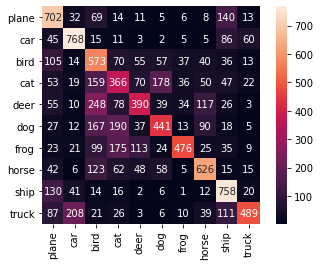

In [145]:
# Show the confusion matrix
cnn_pred = torch.squeeze(torch.cat(cnn_pred, 0))
sns.heatmap(confusion_matrix(test_dataset_targets, cnn_pred.cpu()),
             square=True, annot=True, fmt='d',
             xticklabels = target_names, yticklabels = target_names)

In [146]:
precision_recall_fscore_support(test_dataset_targets, cnn_pred.cpu(), average='macro')

(0.5785641367888431, 0.5589, 0.5569919883516133, None)

In [147]:
precision_recall_fscore_support(test_dataset_targets, cnn_pred.cpu(), average='micro')

(0.5589, 0.5589, 0.5589, None)

# 4. Evaluation

In [153]:
test_accuracies, total_training_time, total_test_time

([0.5436, 0.4999, 0.54],
 [38216.02, 455.7188630104065, 58.587788105010986],
 [1447.73, 5.871274948120117, 3.579383134841919])

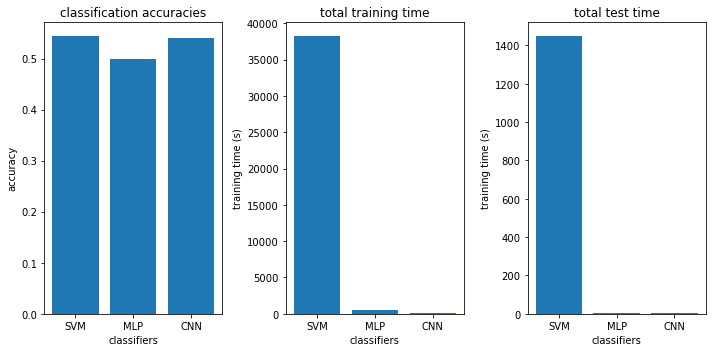

In [154]:
# Summarise the classification accuracy, total training time, and total test time

fig, axes = plt.subplots(nrows =1, ncols = 3, figsize=(10,5))

x_axis = ['SVM', 'MLP', 'CNN']

axes[0].bar(x_axis, test_accuracies)
axes[0].set_title("classification accuracies")
axes[0].set_xlabel("classifiers")
axes[0].set_ylabel("accuracy")

axes[1].bar(x_axis, total_training_time)
axes[1].set_title("total training time")
axes[1].set_xlabel("classifiers")
axes[1].set_ylabel("training time (s)")

axes[2].bar(x_axis, total_test_time)
axes[2].set_title("total test time")
axes[2].set_xlabel("classifiers")
axes[2].set_ylabel("training time (s)")

plt.tight_layout()
plt.show()